In [1]:
# This notebook prepares the dataframes for analysis and runs
# the Random Forest on the combined model (economic and sentiment features) and
# the economic (only) model.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error

In [4]:
# Quick look at the first two lines of the econ CSV
with open('data/econ_vars.csv') as f:
    print(f.readline())
    next(f)
    print(f.readline())

month_date,ur,pi_gr,nyse_gr,gdp_log_diff,tb_sqrt_diff,ics_log_diff,pce_gr_diff

2011-01-01,9.1,0.002028679786119758,0.016528644263536174,-0.0024113163305852225,0.013132595943347536,-0.004034975212179326,-0.004803188602163777



In [5]:
# Set data types for the econ features
dts = {"month_date": str, "ur": np.float64
    , "pi_gr": np.float64, "nyse_gr": np.float64
    , "gdp_log_diff": np.float64, "tb_sqrt_diff": np.float64
    , "ics_log_diff": np.float64, "pce_gr_diff": np.float64}

In [6]:
# Import econ data
data_raw = pd.read_csv("data/econ_vars.csv"
                   , sep=","
                   , skiprows=0
                   , dtype=dts)

In [7]:
# Check the shape of the raw econ data
data_raw.shape

(91, 8)

In [8]:
# Copy raw data
data = data_raw.copy()

In [9]:
# Sort and reset index
data.sort_index(ascending=False, inplace=True)
data.reset_index(drop=True, inplace=True)

In [10]:
# Check the dataframe
data.head()

,month_date,ur,pi_gr,nyse_gr,gdp_log_diff,tb_sqrt_diff,ics_log_diff,pce_gr_diff
0,2018-06-01,4.0,0.003863,-0.001827,0.000000,0.014587,0.002039,-0.001110
1,2018-05-01,3.8,0.003728,0.000941,0.010188,0.037168,-0.008130,0.008168
2,2018-04-01,3.9,-0.004827,-0.002903,0.010188,0.022809,-0.025975,-0.008891
3,2018-03-01,4.1,0.003938,-0.015846,0.000000,0.050844,0.016907,0.007407
4,2018-02-01,4.1,0.003282,-0.053517,0.005479,0.065562,0.040947,0.001663


In [11]:
# Quick look at the first two lines of the sentiment CSV
with open('data/rev_means_vars_stationary.csv') as f:
    print(f.readline())
    next(f)
    print(f.readline())

date,perc_pos_rev_weighted,perc_neg_rev_weighted,perc_uncert_rev_weighted,perc_litig_rev_weighted,perc_modal_wk_rev_weighted,perc_modal_mod_rev_weighted,perc_constrain_rev_weighted,perc_modal_str_rev_weighted_diff

2011-03-01,1.9607048390000001,0.979452392,0.957424913,0.073102265,0.387478896,0.560045154,0.142131806,-0.0495581759999999



In [12]:
# Import sentiment data
sent_raw = pd.read_csv("data/rev_means_vars_stationary.csv"
    , sep=","
    , skiprows=0
    #, dtype=dts 
    , usecols=[0,1,2,3,4,5,6,7,8]
    )

In [13]:
# Check the sentiment data types
sent_raw.dtypes

date                                 object
perc_pos_rev_weighted               float64
perc_neg_rev_weighted               float64
perc_uncert_rev_weighted            float64
perc_litig_rev_weighted             float64
perc_modal_wk_rev_weighted          float64
perc_modal_mod_rev_weighted         float64
perc_constrain_rev_weighted         float64
perc_modal_str_rev_weighted_diff    float64
dtype: object

In [14]:
# Drop any observations with Nan
sent_raw.dropna(inplace=True)

In [15]:
#sort and reset index
sent_raw.sort_values(by='date', ascending=False, inplace=True)
sent_raw.reset_index(drop=True, inplace=True)

In [16]:
# Confirm the shape of the dataframe
sent_raw.shape

(89, 9)

In [17]:
# Check the dataframe
sent_raw.head()

,date,perc_pos_rev_weighted,perc_neg_rev_weighted,perc_uncert_rev_weighted,perc_litig_rev_weighted,perc_modal_wk_rev_weighted,perc_modal_mod_rev_weighted,perc_constrain_rev_weighted,perc_modal_str_rev_weighted_diff
0,2018-06-01,2.043836,0.890239,0.815790,0.094844,0.312586,0.506602,0.101761,0.114463
1,2018-05-01,1.915107,1.074677,0.803269,0.082565,0.401343,0.709648,0.061652,0.054862
2,2018-04-01,1.926137,1.068873,0.777739,0.095691,0.379909,0.669961,0.072092,-0.064945
3,2018-03-01,2.016781,0.979256,0.800769,0.102810,0.402890,0.677247,0.078647,-0.032413
4,2018-02-01,2.004129,0.963727,0.815629,0.098500,0.414424,0.688219,0.091516,0.015687


In [18]:
# Copy raw data
sent = sent_raw.copy()

In [19]:
# Filter econ observations to match the sentiment dataframe
data = data.iloc[0:89,:]

In [20]:
# Combine the econ and sentiment dataframes
data = pd.concat([data,sent], axis=1)

In [21]:
# Replace the integer index with the date column
data = data.set_index("date")

In [22]:
# Create response variable
y_true = data['pce_gr_diff']

In [23]:
# Drop the month_date column and the gdp column
data = data.drop(data.columns[[0,4,7]], axis=1)

In [24]:
# Check the dataframe
data.head()

,ur,pi_gr,nyse_gr,tb_sqrt_diff,ics_log_diff,perc_pos_rev_weighted,perc_neg_rev_weighted,perc_uncert_rev_weighted,perc_litig_rev_weighted,perc_modal_wk_rev_weighted,perc_modal_mod_rev_weighted,perc_constrain_rev_weighted,perc_modal_str_rev_weighted_diff
date,,,,,,,,,,,,,
2018-06-01,4.0,0.003863,-0.001827,0.014587,0.002039,2.043836,0.890239,0.815790,0.094844,0.312586,0.506602,0.101761,0.114463
2018-05-01,3.8,0.003728,0.000941,0.037168,-0.008130,1.915107,1.074677,0.803269,0.082565,0.401343,0.709648,0.061652,0.054862
2018-04-01,3.9,-0.004827,-0.002903,0.022809,-0.025975,1.926137,1.068873,0.777739,0.095691,0.379909,0.669961,0.072092,-0.064945
2018-03-01,4.1,0.003938,-0.015846,0.050844,0.016907,2.016781,0.979256,0.800769,0.102810,0.402890,0.677247,0.078647,-0.032413
2018-02-01,4.1,0.003282,-0.053517,0.065562,0.040947,2.004129,0.963727,0.815629,0.098500,0.414424,0.688219,0.091516,0.015687


In [25]:
# Copy econ features to econ dataframe and drop all sentiment variables
econ = data.drop(data.columns[[5,6,7,8,9,10,11,12]], axis=1)

In [26]:
# Check the dataframe
econ.head()

,ur,pi_gr,nyse_gr,tb_sqrt_diff,ics_log_diff
date,,,,,
2018-06-01,4.0,0.003863,-0.001827,0.014587,0.002039
2018-05-01,3.8,0.003728,0.000941,0.037168,-0.008130
2018-04-01,3.9,-0.004827,-0.002903,0.022809,-0.025975
2018-03-01,4.1,0.003938,-0.015846,0.050844,0.016907
2018-02-01,4.1,0.003282,-0.053517,0.065562,0.040947


In [27]:
# create time series cross validation split
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=3)


In [28]:
# instantiate random forest object
rfreg = RandomForestRegressor()

In [29]:
# establish parameters for grid search object
parameters = {"n_estimators": [50, 100],
    "max_features": [3, 4, 6],
    "min_samples_leaf": [3, 5, 10],     
    "max_depth": [3, None],
    "min_samples_split": [2, 5, 10],
    "bootstrap": [True],
    "random_state": [987]
    }

In [30]:
# create a grid search object
comb_model_gs = GridSearchCV(estimator=rfreg
                   , n_jobs=-1 # parallel execution -1 is all processors
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=tscv # KFolds = 3
                   , scoring="neg_mean_squared_error"
                    )

In [31]:
# fit random forest regressor
comb_model_gs.fit(data, y_true)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    4.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100], 'max_features': [3, 4, 6], 'min_samples_leaf': [3, 5, 10], 'max_depth': [3, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True], 'random_state': [987]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [32]:
# print grid search results sorted by mean test score
comb_model_results = pd.DataFrame(comb_model_gs.cv_results_)
headers = ['rank_test_score','mean_test_score','mean_train_score','mean_fit_time','split0_train_score','split1_train_score','split2_train_score']
comb_model_results.sort_values(by=["rank_test_score"], inplace=True, ascending=True)
comb_model_results[headers].head(10)

,rank_test_score,mean_test_score,mean_train_score,mean_fit_time,split0_train_score,split1_train_score,split2_train_score
93,1,-0.00002,-0.000008,0.194232,-0.000011,-0.000007,-0.000007
91,1,-0.00002,-0.000008,0.203017,-0.000011,-0.000007,-0.000007
39,3,-0.00002,-0.000010,0.182110,-0.000011,-0.000009,-0.000011
37,3,-0.00002,-0.000010,0.176719,-0.000011,-0.000009,-0.000011
43,5,-0.00002,-0.000015,0.177317,-0.000021,-0.000012,-0.000013
47,5,-0.00002,-0.000015,0.183128,-0.000021,-0.000012,-0.000013
45,5,-0.00002,-0.000015,0.175593,-0.000021,-0.000012,-0.000013
42,8,-0.00002,-0.000015,0.092832,-0.000020,-0.000012,-0.000013
44,8,-0.00002,-0.000015,0.087386,-0.000020,-0.000012,-0.000013
46,8,-0.00002,-0.000015,0.093360,-0.000020,-0.000012,-0.000013


In [33]:
# View the optimal random forest model parameters
comb_model_gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=987,
           verbose=0, warm_start=False)

In [34]:
print("Combined model MSE: {}".format(comb_model_gs.best_score_))

Combined model MSE: -2.0119435819526655e-05


In [35]:
# Run a new model using the best model from the grid search
comb_best_model = comb_model_gs.best_params_
rfreg_features = RandomForestRegressor(**comb_best_model)
rfreg_features.fit(data, y_true)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=987,
           verbose=0, warm_start=False)

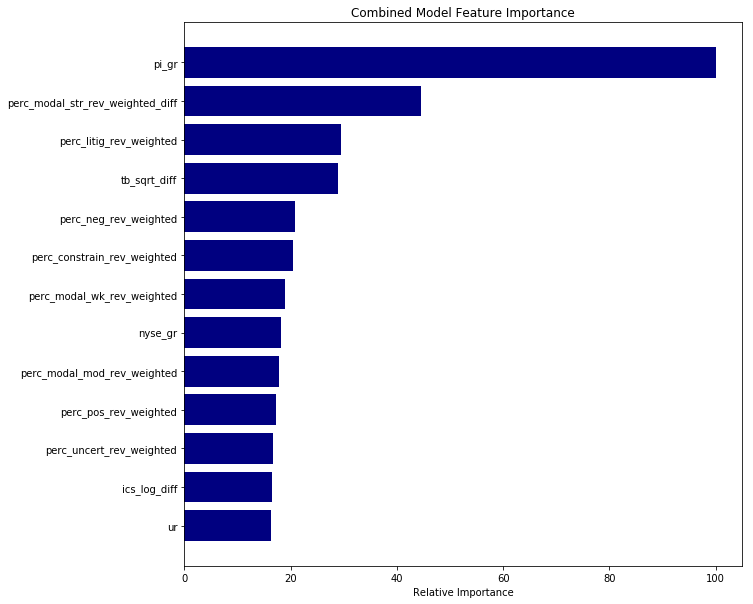

In [36]:
# Plot the feature importances
feature_importance = rfreg_features.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='navy')
plt.yticks(pos, np.asanyarray(data.columns.tolist())[sorted_idx])  # data is X
plt.xlabel('Relative Importance')
plt.title('Combined Model Feature Importance')
plt.show()
#plt.savefig('Random Forest Feature Importance.png')

In [37]:
# establish parameters for grid search object
parameters = {"n_estimators": [50, 100],
    "max_features": [2, 3, 4],
    "min_samples_leaf": [3, 5, 10],     
    "max_depth": [3, None],
    "min_samples_split": [2, 5, 10],
    "bootstrap": [True],
    "random_state": [987]
    }

In [38]:
# create a grid search object
econ_model_gs = GridSearchCV(estimator=rfreg
                   , n_jobs=-1 # parallel execution -1 is all processors
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=tscv # KFolds = 3
                   , scoring="neg_mean_squared_error"
                    )

In [39]:
# fit random forest regressor
econ_model_gs.fit(econ, y_true)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:    4.2s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100], 'max_features': [2, 3, 4], 'min_samples_leaf': [3, 5, 10], 'max_depth': [3, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True], 'random_state': [987]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [40]:
# print results sorted by mean test score
econ_model_results = pd.DataFrame(econ_model_gs.cv_results_)
headers = ['rank_test_score','mean_test_score','mean_train_score','mean_fit_time','split0_train_score','split1_train_score','split2_train_score']
econ_model_results.sort_values(by=["rank_test_score"], inplace=True, ascending=True)
econ_model_results[headers].head(10)

,rank_test_score,mean_test_score,mean_train_score,mean_fit_time,split0_train_score,split1_train_score,split2_train_score
53,1,-0.000021,-0.000023,0.172886,-0.000033,-0.000018,-0.000017
105,1,-0.000021,-0.000023,0.134153,-0.000033,-0.000018,-0.000017
103,1,-0.000021,-0.000023,0.141396,-0.000033,-0.000018,-0.000017
51,1,-0.000021,-0.000023,0.174077,-0.000033,-0.000018,-0.000017
49,1,-0.000021,-0.000023,0.181301,-0.000033,-0.000018,-0.000017
107,1,-0.000021,-0.000023,0.104362,-0.000033,-0.000018,-0.000017
50,7,-0.000021,-0.000023,0.089039,-0.000033,-0.000019,-0.000017
52,7,-0.000021,-0.000023,0.093082,-0.000033,-0.000019,-0.000017
106,7,-0.000021,-0.000023,0.056159,-0.000033,-0.000019,-0.000017
48,7,-0.000021,-0.000023,0.092212,-0.000033,-0.000019,-0.000017


In [41]:
econ_model_gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=987,
           verbose=0, warm_start=False)

In [42]:
print("Economic model MSE: {}".format(econ_model_gs.best_score_))

Economic model MSE: -2.0665388481727326e-05


In [43]:
# Run a new model using the best model from the grid search
econ_best_model = econ_model_gs.best_params_
rfreg_features = RandomForestRegressor(**econ_best_model)
rfreg_features.fit(econ, y_true)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=987,
           verbose=0, warm_start=False)

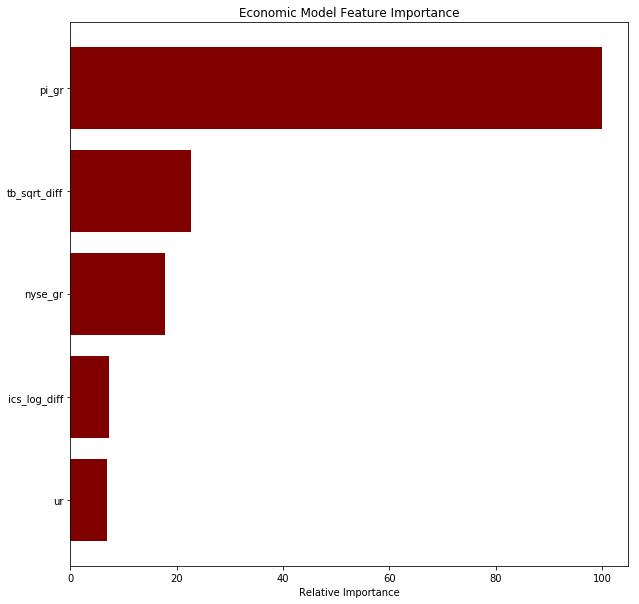

In [44]:
# Plot the feature importances
feature_importance = rfreg_features.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='maroon')
plt.yticks(pos, np.asanyarray(econ.columns.tolist())[sorted_idx])  # econ is X
plt.xlabel('Relative Importance')
plt.title('Economic Model Feature Importance')
plt.show()
#plt.savefig('Random Forest Feature Importance.png')